<a href="https://colab.research.google.com/github/22A95A0510-2625/Infosys_SpringBoard_Project/blob/main/Prediction_with_LSTM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import pandas as pd
import yfinance as yf
import tensorflow as tf
from tensorflow.keras.layers import Dense, LSTM
from tensorflow.keras.models import Sequential
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
import os

In [ ]:
# Ensure the directory exists
plot_dir = 'results/plots'
os.makedirs(plot_dir, exist_ok=True)

# Ensure the directory exists
model_dir = 'models/'
os.makedirs(model_dir, exist_ok=True)

# Ensure the directory exists
data_dir = 'data/'
os.makedirs(data_dir, exist_ok=True)

# Ensure the directory exists
pred_dir = 'results/prediction/'
os.makedirs(pred_dir, exist_ok=True)

[*********************100%***********************]  1 of 1 completed


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 266ms/step


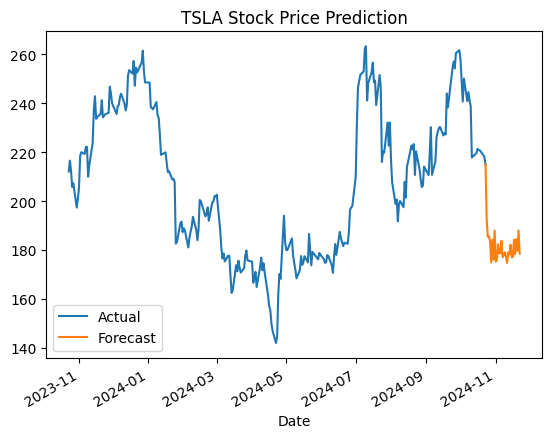

In [ ]:
pd.options.mode.chained_assignment = None
tf.random.set_seed(0)

def stock_prediction(ticker, prediction_days):
    # download the data
    df = yf.download(tickers=[ticker], period='1y')
    if df.empty:
        raise ValueError(f"No data found for ticker {ticker}")

    y = df['Close'].ffill().values.reshape(-1, 1)

    # scale the data
    scaler = MinMaxScaler(feature_range=(0, 1))
    y = scaler.fit_transform(y)

    # generate the input and output sequences
    n_lookback = 60  # length of input sequences (lookback period)
    n_forecast = prediction_days  # length of output sequences (forecast period)

    X = []
    Y = []

    for i in range(n_lookback, len(y) - n_forecast + 1):
        X.append(y[i - n_lookback: i])
        Y.append(y[i: i + n_forecast])

    X = np.array(X)
    Y = np.array(Y)

    # fit the model
    model = Sequential()
    model.add(LSTM(units=50, return_sequences=True))
    model.add(LSTM(units=50))
    model.add(Dense(n_forecast))

    model.compile(loss='mean_squared_error', optimizer='adam')
    model.fit(X, Y, epochs=100, batch_size=32, verbose=0)

    # generate the forecasts
    X_ = y[-n_lookback:]  # last available input sequence
    X_ = X_.reshape(1, n_lookback, 1)

    Y_ = model.predict(X_).reshape(-1, 1)
    Y_ = scaler.inverse_transform(Y_)

    # organize the results in a data frame
    df_past = df[['Close']].reset_index()
    df_past.rename(columns={'index': 'Date', 'Close': 'Actual'}, inplace=True)
    df_past['Date'] = pd.to_datetime(df_past['Date'])
    df_past.loc[df_past.index[-1], 'Forecast'] = df_past.loc[df_past.index[-1], 'Actual']

    df_future = pd.DataFrame(columns=['Date', 'Actual', 'Forecast'])
    df_future['Date'] = pd.date_range(start=df_past['Date'].iloc[-1] + pd.Timedelta(days=1), periods=n_forecast)
    df_future['Forecast'] = Y_.flatten()
    df_future['Actual'] = np.nan

    results = pd.concat([df_past, df_future]).set_index('Date')

    # plot the results
    results.plot(title=f'{ticker} Stock Price Prediction')
    plt.savefig(os.path.join(plot_dir, f'{ticker}_predictions.png'))
    plt.show()
    return results

ticker='TSLA'
pred_days=30
results=stock_prediction(ticker, pred_days)

In [ ]:
import holidays

# Remove holidays from the forecast
us_holidays = holidays.US()
resultspred = results[~results.index.isin(us_holidays.keys())]
resultspred = resultspred[~resultspred.index.weekday.isin([5, 6])]
resultspred = resultspred[~np.isnan(resultspred['Forecast'])]

In [ ]:
# Create a DataFrame with dates and LSTM predictions

df_pred=resultspred.drop('Actual',axis=1)

# Save the DataFrame to a CSV file in the data folder
df_pred.to_csv(data_dir + f'{ticker}_predictions.csv', index=True)

# Save the DataFrame to a CSV file in the predictions folder
df_pred.to_csv(pred_dir+ f'{ticker}_predictions.csv', index=True)

In [ ]:
df_pred

,Forecast
Date,
2024-10-23,215.011093
2024-10-24,192.743500
2024-10-25,185.432266
2024-10-28,174.919022
2024-10-29,184.210739
2024-10-30,176.067383
2024-10-31,187.972031
2024-11-01,175.268097
2024-11-04,178.698257
